In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
#General eval metrics
def evaluate_predictions(meta_df, probs, target):
    df = meta_df.copy()
    df[f'prob_{target}'] = probs

    df = df.sort_values(by=['year', 'event', 'GridPosition'])
    df[f'rank_{target}'] = df.groupby('event')[f'prob_{target}'].rank(ascending=False, method='first')

    first_place_acc = (df[df["Position"] == 1][f'rank_{target}'] == 1).mean()
    df['is_podium_actual'] = df["Position"].isin([1, 2, 3])
    df['is_podium_predicted'] = df[f'rank_{target}'] <= 3
    podium_acc = (df['is_podium_actual'] == df['is_podium_predicted']).mean()
    total_rank_acc = (df["Position"] == df[f'rank_{target}']).mean()

    print(f"\nEvaluation - Target: {target}")
    print("First place accuracy:", round(first_place_acc, 4))
    print("Podium accuracy:", round(podium_acc, 4))
    print("Exact position accuracy:", round(total_rank_acc, 4))

    return df


In [ ]:
def run_logreg(df_path, target, param_search=True):
    df = pd.read_csv(df_path)

    # Targets
    df["is_winner"] = (df["Position"] == 1).astype(int)
    df["is_podium"] = df["Position"].isin([1, 2, 3]).astype(int)

    # Meta for evaluation
    meta = df[["FullName", "event", "year", "TeamFamily", "GridPosition", "Position"]].copy()

    # Feature prep
    df = df.drop(columns=["year", "Position"])
    df = pd.get_dummies(df, columns=["event", "TeamFamily", "FullName"], drop_first=False)

    y = df[target]
    X = df.drop(columns=["is_winner", "is_podium"])
    X = X.fillna(-1)

    # Identify and scale only non-binary (non-OHE) features
    binary_prefixes = ("event_", "TeamFamily_", "FullName_")
    non_binary_cols = [col for col in X.columns if not col.startswith(binary_prefixes)]
    binary_cols = [col for col in X.columns if col.startswith(binary_prefixes)]

    scaler = StandardScaler()
    X[non_binary_cols] = scaler.fit_transform(X[non_binary_cols])

    feature_names = X.columns

    # Split data
    train_mask = meta["year"] <= 2022
    valid_mask = meta["year"] == 2023
    test_mask = meta["year"] == 2024

    X_train, y_train = X[train_mask], y[train_mask]
    X_valid, y_valid = X[valid_mask], y[valid_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    meta_test = meta[test_mask].reset_index(drop=True)

    # Oversample
    over = RandomOverSampler(random_state=42)
    X_os, y_os = over.fit_resample(X_train, y_train)

    # Logistic Regression
    if param_search:
        param_dist = {
            "C": uniform(0.001, 10),
            "penalty": ["l2"],
            "solver": ["lbfgs"],
            "max_iter": [1000]
        }

        search = RandomizedSearchCV(
            estimator=LogisticRegression(),
            param_distributions=param_dist,
            n_iter=50,
            scoring="neg_log_loss",
            cv=5,
            verbose=1,
            n_jobs=-1
        )
        search.fit(X_os, y_os)
        model = search.best_estimator_
    else:
        model = LogisticRegression(C=1.0, max_iter=1000)
        model.fit(X_os, y_os)

    # Retrain on full train + val
    X_full = pd.concat([X_train, X_valid])
    y_full = pd.concat([y_train, y_valid])
    X_full_os, y_full_os = over.fit_resample(X_full, y_full)
    model.fit(X_full_os, y_full_os)

    # Predict
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)

    # Evaluation
    print("\n--- Test Metrics---")
    print("Log loss:", round(log_loss(y_test, probs), 4))
    print("AUC:", round(roc_auc_score(y_test, probs), 4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=4))

    # Ranking-based metrics
    results = evaluate_predictions(meta_test, probs, target)

    # Permutation Importance
    print("\n--- Permutation Importance ---")
    perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = perm.importances_mean.argsort()[::-1][:10]
    plt.figure(figsize=(10, 5))
    plt.barh(range(10), perm.importances_mean[sorted_idx])
    plt.yticks(range(10), [feature_names[i] for i in sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"Top 10 Feature Importances - {target} (LogReg)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # PDP
    print("\n--- Partial Dependence (Top 6) ---")
    top_features = [feature_names[i] for i in sorted_idx[:6]]
    PartialDependenceDisplay.from_estimator(model, X, top_features, grid_resolution=20)
    plt.tight_layout()
    plt.show()

    return model, results



Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Test Metrics---
Log loss: 0.3904
AUC: 0.924
Confusion Matrix:
[[316  91]
 [  5  67]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9844    0.7764    0.8681       407
           1     0.4241    0.9306    0.5826        72

    accuracy                         0.7996       479
   macro avg     0.7042    0.8535    0.7254       479
weighted avg     0.9002    0.7996    0.8252       479


Evaluation - Target: is_podium
First place accuracy: 0.4167
Podium accuracy: 0.8914
Exact position accuracy: 0.142

--- Permutation Importance ---


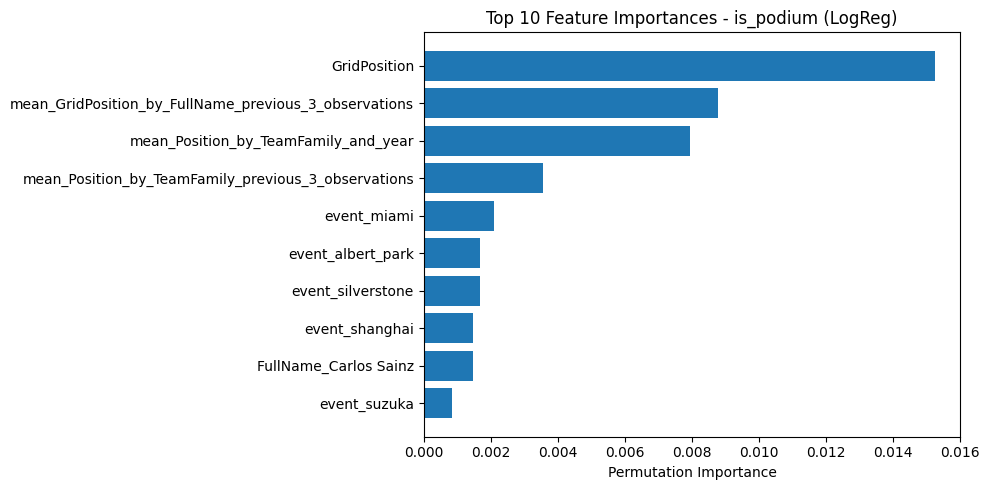


--- Partial Dependence (Top 6) ---


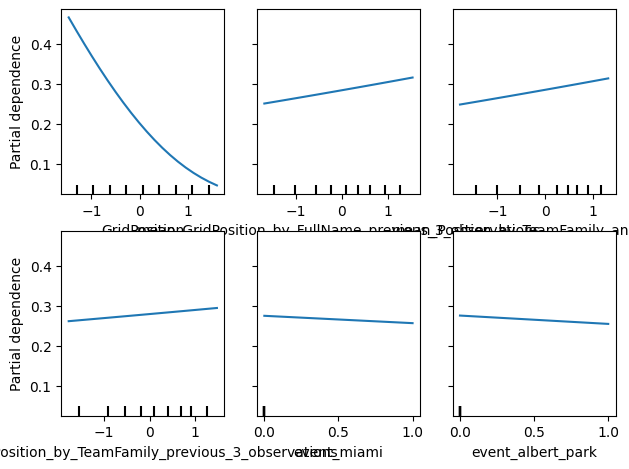

In [ ]:
model_podium, results_podium = run_logreg(
    df_path="Data/race_feature_2015_2024.csv",
    target="is_podium",
    param_search=True
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Test Metrics---
Log loss: 0.2708
AUC: 0.9288
Confusion Matrix:
[[398  57]
 [  7  17]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9827    0.8747    0.9256       455
           1     0.2297    0.7083    0.3469        24

    accuracy                         0.8664       479
   macro avg     0.6062    0.7915    0.6363       479
weighted avg     0.9450    0.8664    0.8966       479


Evaluation - Target: is_winner
First place accuracy: 0.3333
Podium accuracy: 0.8747
Exact position accuracy: 0.119

--- Permutation Importance ---


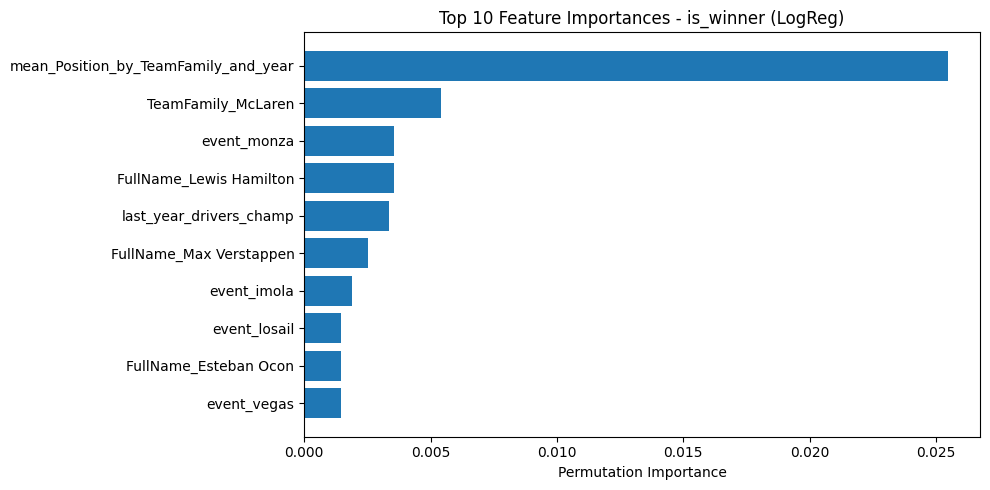


--- Partial Dependence (Top 6) ---


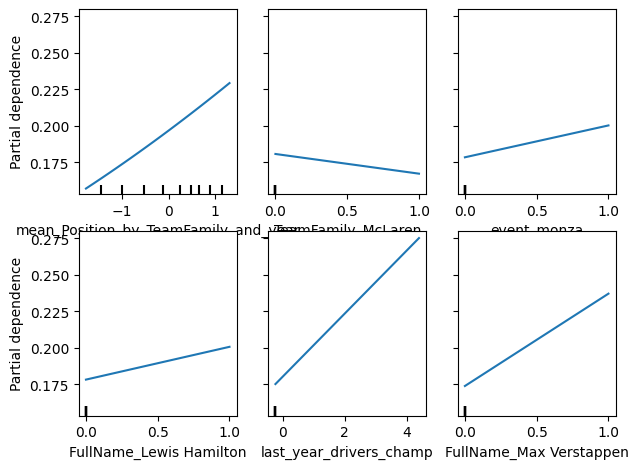

In [ ]:
model_winner, results_winner = run_logreg(
    df_path="Data/race_feature_2015_2024.csv",
    target="is_winner",
    param_search=True
)

In [6]:
results_winner.to_excel("C:/Users/apidb/OneDrive/Bureau/Lagg/LRwinner.xlsx")
results_podium.to_excel("C:/Users/apidb/OneDrive/Bureau/Lagg/LRpodium.xlsx")